In [3]:
import torch
from torch.utils.data import DataLoader

import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt
import cmath
from scipy import integrate
import os
import h5py
import seaborn as sns


# From this project modules:
from Python.src.LSTM_mudule import LSTM
from Python.src.DataProcessing import Propagator_Dataset

# Enable interactive plot
%matplotlib inline
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

# To latex plots:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

In [4]:
from functions import LSTM  # to use the trainined models

# Visualization data generated
___

## Plot Input & Output of data generated

In [5]:
# To load the file

directory = './DataNew/'
name_data = 'ngrid128_delta_10012025.h5'
file_path = directory + name_data

# --- Load Data ---
with h5py.File(file_path, 'r') as h5f:
    X_vis = h5f['dataset_X'][:]
    y_vis = h5f['dataset_y'][:]

In [6]:
# --- Inspect Shape ---
X_shape = X_vis.shape  # e.g., (num_trajectories, num_timesteps, num_features)

# --- Assign Shape Dimensions ---
num_trajectories, num_timesteps, num_features = X_shape

# --- Infer Structure ---
num_grid_points = num_features // 3  # assuming 3 features per grid point: real, imag, potential

# --- Print Information ---
print(" Data loaded from:", name_data)
print(f" Shape of X_vis: {X_shape}")
print(f"  • Number of trajectories or total data      : {num_trajectories}")
print(f"  • Number of time steps (fs)                 : {num_timesteps}")
print(f"  • Total features per time step: {num_features}")
print(f"    ↳ Composed of:")
print(f"      - Real part     : {num_grid_points} grid points")
print(f"      - Imag part     : {num_grid_points} grid points")
print(f"      - Potential     : {num_grid_points} grid points")


 Data loaded from: ngrid128_delta_10012025.h5
 Shape of X_vis: (10, 1000, 384)
  • Number of trajectories or total data      : 10
  • Number of time steps (fs)                 : 1000
  • Total features per time step: 384
    ↳ Composed of:
      - Real part     : 128 grid points
      - Imag part     : 128 grid points
      - Potential     : 128 grid points


In [7]:
# --- Inspect Shape of y_vis ---
y_shape = y_vis.shape 
y_num_trajectories, y_num_timesteps, y_num_features = y_shape

# --- Infer Structure of y_vis ---
y_num_grid_points = y_num_features // 2  # real and imag only

# --- Print Information for y_vis ---
print("\n Shape of y_vis:", y_shape)
print(f"  • Number of trajectories or total data: {y_num_trajectories}")
print(f"  • Number of time steps (fs)           : {y_num_timesteps}")
print(f"  • Total features per time step        : {y_num_features}")
print(f"    ↳ Composed of:")
print(f"      - Real part : {y_num_grid_points} grid points")
print(f"      - Imag part : {y_num_grid_points} grid points")



 Shape of y_vis: (10, 1000, 256)
  • Number of trajectories or total data: 10
  • Number of time steps (fs)           : 1000
  • Total features per time step        : 256
    ↳ Composed of:
      - Real part : 128 grid points
      - Imag part : 128 grid points


In [8]:
assert num_trajectories == y_num_trajectories, "Mismatch in trajectory count"
assert num_timesteps == y_num_timesteps, "Mismatch in time steps"
assert num_grid_points == y_num_grid_points, "Mismatch in grid points between input and output"

In [9]:
# General parameters
a = -1.5  # initial point in angstroms
b = 1.5  # final point in angstroms

In [32]:
def plot_wavefunction_frame(X, y, dat=0, time=0, grid_range=(-1.5, 1.5), color=None, energy_scale=30):
    """
    Plots the input and output wavefunction at a specific trajectory and time step.

    Parameters:
        X (tensor): Input tensor of shape (trajectories, timesteps, features)
        y (tensor): Output tensor of same shape, but with only real & imag parts
        dat (int): Trajectory index
        time (int): Time step index
        grid_range (tuple): Spatial range in Angstroms, default (-1.5, 1.5)
        color (list): Optional list of colors [real, imag, ?, potential]
        energy_scale (float): Scaling factor for wavefunction amplitude
    """
    num_grid_points = X.shape[2] // 3  # Assuming 3 features per grid point: real, imag, potential
    a, b = grid_range
    r_n = torch.linspace(a, b, num_grid_points)

    # --- Extract Input Components ---
    In_real = X[dat, time, 0:num_grid_points]
    In_imag = X[dat, time, num_grid_points:2*num_grid_points]
    In_pote = X[dat, time, 2*num_grid_points:3*num_grid_points]

    # --- Extract Output Components ---
    Ou_real = y[dat, time, 0:num_grid_points]
    Ou_imag = y[dat, time, num_grid_points:2*num_grid_points]

    # --- Plotting ---
    fig, axs = plt.subplots(2, 1, figsize=(6, 8))

    # Plot input
    axs[0].plot(r_n, In_pote * (1 / 1.5936e-3), "-", label="$V(r,t)$", color=color[3] if color else 'gray')
    axs[0].plot(r_n, In_real * energy_scale, label="$\psi_{real}(r, t)$", color=color[0] if color else 'tab:blue')
    axs[0].plot(r_n, In_imag * energy_scale, label="$\psi_{imag}(r, t)$", color=color[1] if color else 'tab:orange')
    axs[0].set_title("Input: $t$")

    # Plot output
    axs[1].plot(r_n, (In_real + Ou_real) * energy_scale, label="$\psi_{real}(r, t+1)$", color=color[0] if color else 'tab:blue')
    axs[1].plot(r_n, (In_imag + Ou_imag) * energy_scale, label="$\psi_{imag}(r, t+1)$", color=color[1] if color else 'tab:orange')
    axs[1].set_title("Output: $t+1$")

    for ax in axs:
        ax.set_ylim([-15, 50])
        ax.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
        ax.legend()
        ax.label_outer()

    plt.tight_layout()
    plt.show()


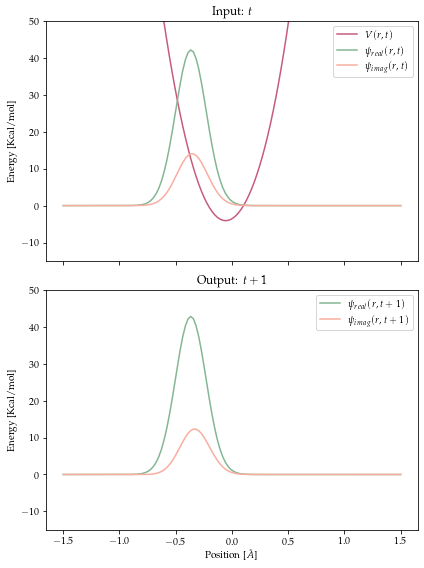

In [33]:
plot_wavefunction_frame(X_vis, y_vis, dat=3, time=1, grid_range=(-1.5, 1.5), color=color)

## Potential through time visualization

In [34]:
import matplotlib.pyplot as plt
import torch

def plot_potential_over_time(X, dat=0, time_steps=None, grid_range=(-1.5, 1.5), energy_scale=(1/1.5936e-3), 
                             ylim=(-15, 80), color=None):
    """
    Plots the potential V(r, t) over space for selected time steps.

    Parameters:
        X (tensor): Input tensor of shape (trajectories, timesteps, features)
        dat (int): Trajectory index to visualize
        time_steps (list): List of time indices to plot (e.g., [0, 20, 40])
        grid_range (tuple): Spatial domain in Angstroms
        energy_scale (float): AU to kcal/mol conversion factor
        ylim (tuple): Y-axis limits
        color (list): Optional list of colors for each line
    """
    num_grid_points = X.shape[2] // 3  # Assuming 3 features per grid point: real, imag, potential
    r_n = torch.linspace(grid_range[0], grid_range[1], num_grid_points)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(r"$V(r, t)$")
    ax.set_xlabel('Position [$\AA$]')
    ax.set_ylabel('Energy [Kcal/mol]')
    ax.set_ylim(ylim)

    for i, t in enumerate(time_steps):
        assert t < num_timesteps, f"Time index {t} out of bounds!"
        pote_t = X[dat, t, 2 * num_grid_points : 3 * num_grid_points] * energy_scale
        col = color[i] if color else None
        ax.plot(r_n, pote_t, "-", label=f"{t} fs", color=col)

    ax.legend()
    plt.tight_layout()
    #plt.savefig('/home/jessica/Tesis/Paper/img/ExamplesPotential_data7.pdf')
    plt.show()


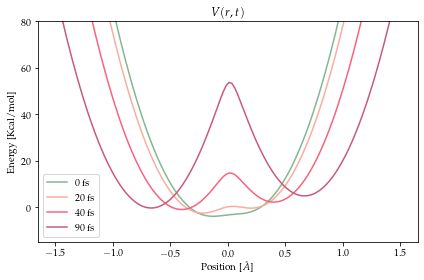

In [48]:
plot_potential_over_time(X_vis, dat=1, time_steps=[0, 20, 40, 90], color=color)


## Wavefunction through time visualization

In [67]:
# new
def plot_wavefunction_heatmap(X, dat=0, grid_range=(-1.5, 1.5),n_xticks=5, 
                              n_yticks=4, save_path=None,
                              time_slice=None):
    """
    Plots a heatmap of |psi(r, t)|^2 over space and time (optionally sliced in time).

    Parameters:
        X (tensor): Input tensor of shape (trajectories, timesteps, features).
        dat (int): Trajectory index.
        grid_range (tuple): (min, max) range of spatial domain in Angstroms.
        n_xticks (int): Number of ticks on the time axis.
        n_yticks (int): Number of ticks on the position axis.
        save_path (str or None): If provided, saves the plot to this path.
        time_slice (tuple or None): Optional (start, end) indices to slice the time axis.
                                   If None, uses entire trajectory.
    """

    num_trajectories, num_timesteps, num_features = X.shape
    num_grid_points = num_features // 3
    time_range_fs = num_timesteps

    assert dat < num_trajectories, f"Trajectory index {dat} out of bounds!"

    # Slice the time dimension if requested
    if time_slice:
        start, end = time_slice
        assert 0 <= start < end <= num_timesteps, "Invalid time_slice indices!"
        X_segment = X[dat, start:end, :]
        timesteps_to_plot = end - start
    else:
        X_segment = X[dat, :, :]
        timesteps_to_plot = num_timesteps
        start = 0  # for labels if needed

    # Spatial grid
    r_n = torch.linspace(grid_range[0], grid_range[1], num_grid_points)

    # Extract real and imaginary parts (transpose so space is rows, time is cols)
    X_r = X_segment[:, 0:num_grid_points].T
    X_i = X_segment[:, num_grid_points:2*num_grid_points].T

    # Compute |psi|^2
    X_complex = np.vectorize(complex)(X_r, X_i)
    X_dens = (np.abs(X_complex))**2

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(X_dens, cbar_kws={'label': r'$|\psi(r,t)|^2$ [$1/\mathrm{\AA}$]'}, ax=ax)

    # --- X-axis (time) ---
    xtick_locs = np.linspace(0, timesteps_to_plot, n_xticks, dtype=int)
    if time_range_fs:
        total_fs = time_range_fs * (timesteps_to_plot / num_timesteps)
        xtick_labels = [f"{int(total_fs * i / (timesteps_to_plot)) + int(start * (time_range_fs / num_timesteps))}" for i in xtick_locs]
        ax.set_xlabel("Time [fs]")
    else:
        xtick_labels = [str(i + start) for i in xtick_locs]
        ax.set_xlabel("Time [steps]")
    ax.set_xticks(xtick_locs)
    ax.set_xticklabels(xtick_labels)

    # Add vertical lines at specified times
    for t in [250, 500, 750]:
        ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

    # --- Y-axis (position) ---
    ytick_locs = np.linspace(0, num_grid_points - 1, n_yticks, dtype=int)
    ytick_labels = np.linspace(grid_range[0], grid_range[1], n_yticks)
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels([f"{y:.1f}" for y in ytick_labels])
    ax.set_ylabel("Position [$\mathrm{\AA}$]")

    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {save_path}")
    plt.show()


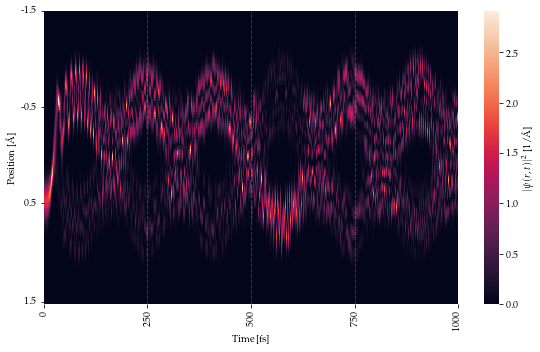

In [68]:
# new
plot_wavefunction_heatmap(X_vis, dat=1, time_slice=(0, num_timesteps))


## Initial wavepacket

In [36]:
def plot_wavefunction_component(X, dat=0, time_step=0, component='real',
                                 grid_range=(-1.5, 1.5), color=None, save_path=None):
    """
    Plots either the real or imaginary component of the wavefunction at a specific time step.

    Args:
        X (ndarray): Shape (n_trajectories, seq_len, 2 * num_grid_points)
        dat (int): Index of trajectory
        time_step (int): Time step to visualize
        component (str): 'real' or 'imag'
        grid_range (tuple): Range of grid positions
        color (list): List of colors to use
        save_path (str): Path to save the plot (optional)
    """
    assert component in ['real', 'imag'], "component must be 'real' or 'imag'"
    assert 0 <= time_step < X.shape[1], "Invalid time step."
    
    num_grid_points = X.shape[2] // 3  # Assuming 3 features per grid point: real, imag, potential
    r_n = np.linspace(grid_range[0], grid_range[1], num_grid_points)

    psi_real = X[dat, time_step, :num_grid_points]
    psi_imag = X[dat, time_step, num_grid_points:2 * num_grid_points]

    if color is None:
        color = ["#1f77b4", "#ff7f0e"]  # Default colors for real and imag

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlabel('Position [$\AA$]')
    ax.set_ylabel(r'$\psi(r,t)$')
    ax.set_title(fr"Wavefunction {component} part at $t={time_step}$")

    if component == 'real':
        ax.plot(r_n, psi_real, label=fr"$\psi_{{real}}(r,t={time_step})$", color=color[0])
    else:
        ax.plot(r_n, psi_imag, label=fr"$\psi_{{imag}}(r,t={time_step})$", color=color[1])

    ax.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Wavefunction {component} plot saved to: {save_path}")
    plt.show()


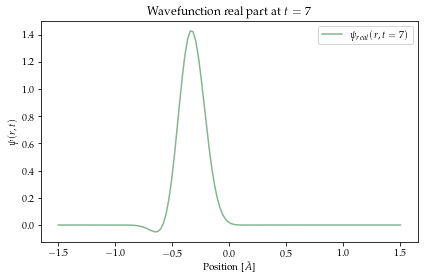

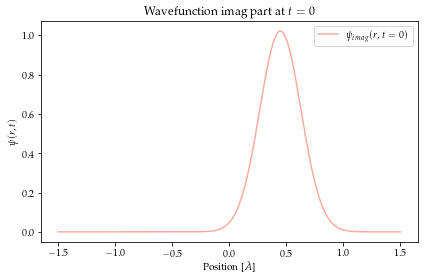

In [ ]:
# Plot real part at t = 7, trajectory = 3
plot_wavefunction_component(X_vis, dat=3, time_step=7, component='real', color=color)

# Plot imaginary part at t = 0, trajectory = 1
plot_wavefunction_component(X_vis, dat=1, time_step=0, component='imag', color=color)


## Checking normalization of wave packet at random time t $[\AA]$

In [50]:
def plot_probability_density(X, dat=0, time_step=0, grid_range=(-1.5, 1.5), color=None, save_path=None):
    """
    Plots the probability density |ψ(r,t)|² at a given trajectory and time step.

    Parameters:
        X (np.ndarray): Tensor with shape (trajectories, timesteps, features).
        dat (int): Index of the trajectory.
        time_step (int): Time step to visualize.
        grid_range (tuple): Range (a, b) for position axis in Å.
        color (str): Color for the plot line (optional).
        save_path (str): Path to save the figure (optional).
    """
    num_grid_points = X.shape[2] // 3  # Assuming 3 features per grid point: real, imag, potential
    r_n = np.linspace(grid_range[0], grid_range[1], num_grid_points)

    # Extract real and imag parts
    In_real = X[dat, time_step, 0:num_grid_points]
    In_imag = X[dat, time_step, num_grid_points:2*num_grid_points]

    # Build complex wavefunction and convert to Angstroms (sqrt of inverse Bohr radius)
    conversion = np.sqrt(1 / 0.5291775)
    psi_complex = In_real * conversion + 1j * In_imag * conversion

    # Probability density
    prob_density = np.abs(psi_complex) ** 2

    # test of the integral, it must be 1:
    integral = np.trapz(prob_density, r_n)
    print(f"Integral of |ψ(r,t)|²: {integral:.6f}")

    # Plot
    fig, ax = plt.subplots()
    plot_color = color if color is not None else 'blue'
    ax.plot(r_n, prob_density, color=plot_color)

    ax.set_xlabel('Position [$\AA$]')
    ax.set_ylabel(r'$|\psi(r,t)|^2$   $[1/\AA]$')
    plt.gcf().set_size_inches(6, 4)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


Integral of |ψ(r,t)|²: 1.000000


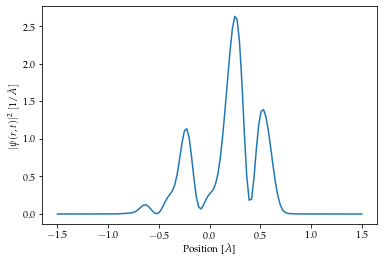

In [57]:
plot_probability_density(X_vis, dat=2, time_step=605, color='C0')

1.0000000000000002

## Checking normalization of wave packet at random time t [a.u.]

In [62]:
a = -1.5  # initial point in angstroms
b = 1.5  # final point in angstroms
n_grid = num_grid_points
r_n = np.linspace(a,b,n_grid)*(1/0.5291775)  # angstroms to au
time = int(400)

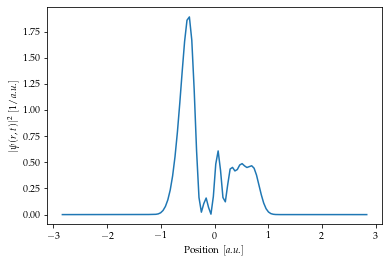

In [63]:
X_r = X_vis[dat,time,0:n_grid]
X_i = X_vis[dat,time,n_grid:2*n_grid]
X_de = np.vectorize(complex)(X_r,X_i)
X_dens = ((np.abs(X_de))**2)


fig, ax = plt.subplots()
ax.plot(r_n, X_dens)
ax.set(xlabel='Position $[a.u.]$', ylabel='$|\psi(r,t)|^2$   $[1/a.u.]$')
plt.show()

In [64]:
integral = np.trapz(X_dens, r_n)
print(f"Integral of |ψ(r,t)|² in [a.u.]: {integral:.6f}")


Integral of |ψ(r,t)|² in [a.u.]: 1.000000


# MOVED to another notebook ----------------------------------------

In [ ]:
#a

# Predicted data visualization and comparisons
___

## Plot comparison LSTM predictions vs DVR

In [31]:
n_grid = 128

In [26]:
test_path_dat = directory+name_data

In [27]:
dataset = Propagator_Dataset(path=test_path_dat, data='dataset_X', targets='dataset_y')

In [28]:
batch_size = 10

In [29]:
test_loader = DataLoader(dataset, batch_size=batch_size)

In [30]:
for X, y in test_loader:
    print("Test data:")
    print(f"Shape of X in test loader: {X.shape}")
    print(f"Shape of y in test loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Test data:
Shape of X in test loader: torch.Size([10, 1000, 384])
Shape of y in test loader: torch.Size([10, 1000, 256])
Batch size: 10


In [31]:
# Calling the trained model
device = 'cpu'
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_5040trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))

# if cuda is available uncomment:
#model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth')

In [66]:
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Input = X
    
    Output = y

    with torch.inference_mode():
        Prediction = model(X.float())
    break

In [67]:
print(Input.shape)
print(Prediction.shape)
print(Output.shape)

torch.Size([10, 1000, 384])
torch.Size([10, 1000, 256])
torch.Size([10, 1000, 256])


In [73]:
r_n = torch.linspace(a,b,n_grid)
dat=2

X_r = Output[dat,:,0:n_grid].T
X_i = Output[dat,:,n_grid:2*n_grid].T
X_de = np.vectorize(complex)(X_r,X_i)

X_dens = ((np.abs(X_de))**2)

<IPython.core.display.Javascript object>


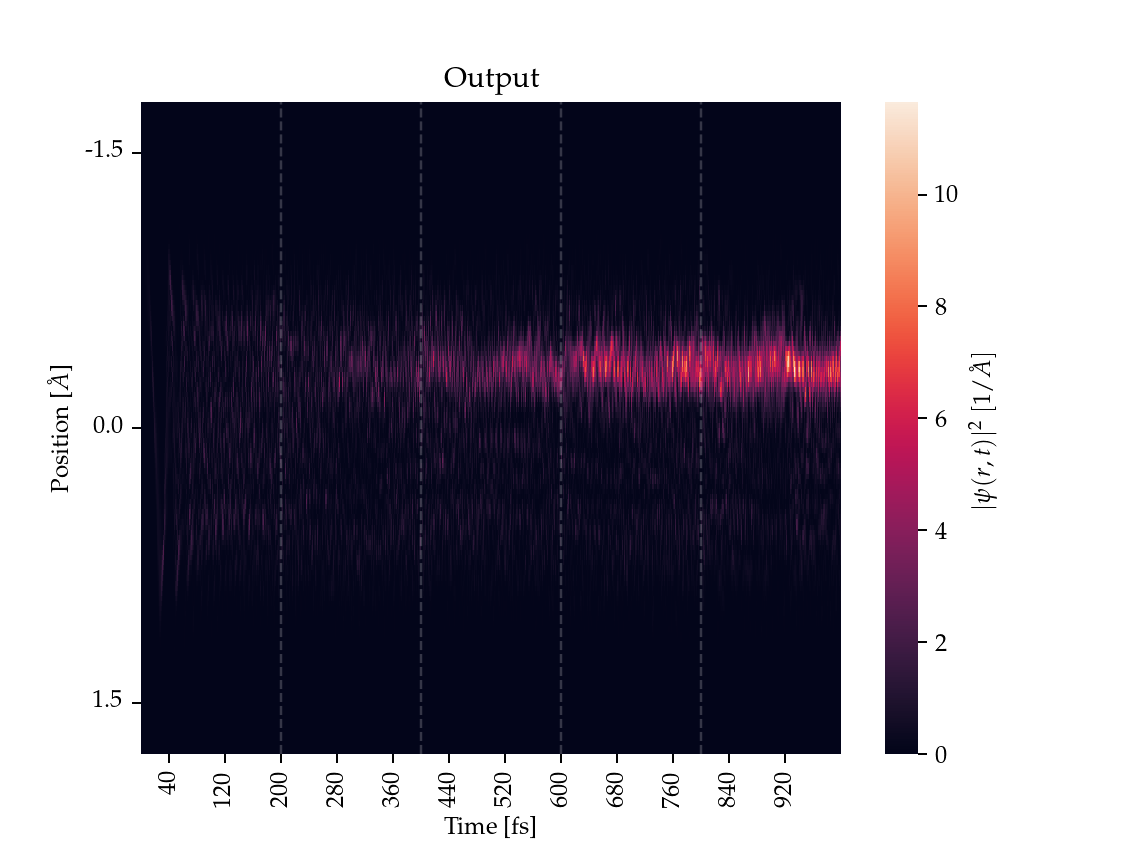

In [74]:
fig, ax = plt.subplots()

ax = sns.heatmap(X_dens, square=False, cbar_kws={'label': '$|\psi(r,t)|^2$ $[1/\AA]$'})
ax.set_title('Output')

ax.set_xticks(range(40, 1000, 80))
ax.set_xticklabels(c for c in np.arange(40, 1000, 80))

ax.set_yticks(range(10, 119, 54))
ax.set_yticklabels(f'{c:.1f}' for c in np.arange(-1.5, 1.6, 1.5))

# Add vertical lines at specified times
for t in [200, 400, 600, 800]:
    ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

plt.xlabel("Time [fs]") 
plt.ylabel("Position [$\AA$]") 
plt.show()

In [75]:
r_n = torch.linspace(a,b,n_grid)

X_r = Prediction[dat,:,0:n_grid].T
X_i = Prediction[dat,:,n_grid:2*n_grid].T
X_de = np.vectorize(complex)(X_r,X_i)

X_dens = ((np.abs(X_de))**2)

<IPython.core.display.Javascript object>


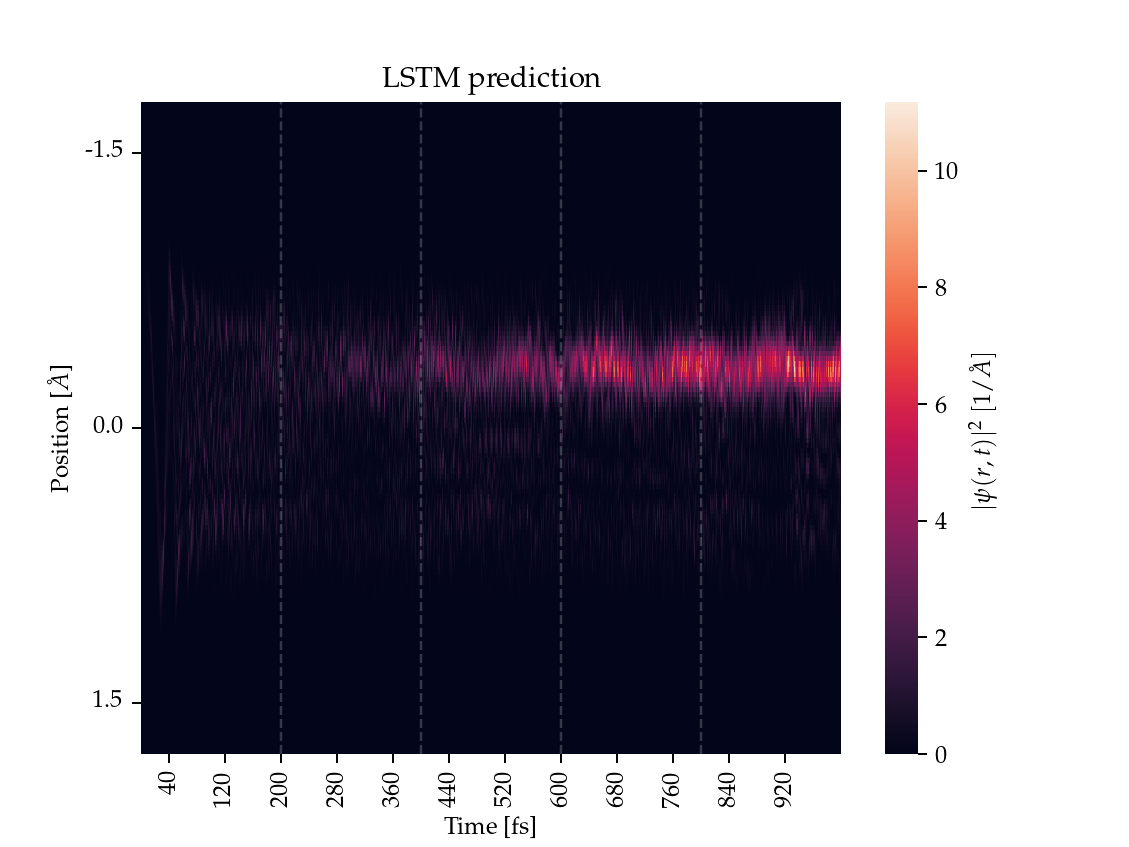

In [76]:
fig, ax = plt.subplots()

ax = sns.heatmap(X_dens, square=False, cbar_kws={'label': '$|\psi(r,t)|^2$ $[1/\AA]$'})
ax.set_title('LSTM prediction')
ax.set_xticks(range(40, 1000, 80))
ax.set_xticklabels(c for c in np.arange(40, 1000, 80))

ax.set_yticks(range(10, 119, 54))
ax.set_yticklabels(f'{c:.1f}' for c in np.arange(-1.5, 1.6, 1.5))

# Add vertical lines at specified times
for t in [200, 400, 600, 800]:
    ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

plt.xlabel("Time [fs]") 
plt.ylabel("Position [$\AA$]") 
plt.show()

## Real and Complex parts of wavefunction comparison

In [77]:
def wavefunction(part, time, source):
    
    if source == 'input':
        if part == 'real':
            in_real_t = Input[dat,time,0:n_grid].detach().numpy()
            return in_real_t
        
        if part == 'complex':
            in_imag_t = Input[dat,time,n_grid:n_grid*2].detach().numpy()
            return in_imag_t
        
        
    if source == 'output':
        if part == 'real':
            ou_real_t = Output[dat,time,0:n_grid].detach().numpy()
            return ou_real_t
        
        if part == 'complex':
            ou_imag_t = Output[dat,time,n_grid:n_grid*2].detach().numpy()
            return ou_imag_t
        
    if source == 'prediction':
        if part == 'real':
            pred_real_t = Prediction[dat,time,0:n_grid].detach().numpy()
            return pred_real_t
        
        if part == 'complex':
            pred_imag_t = Prediction[dat,time,n_grid:n_grid*2].detach().numpy()
            return pred_imag_t

In [78]:
def potential(time):
    pot = Input[dat,time,n_grid*2:n_grid*3].detach().numpy()
    return pot

<IPython.core.display.Javascript object>


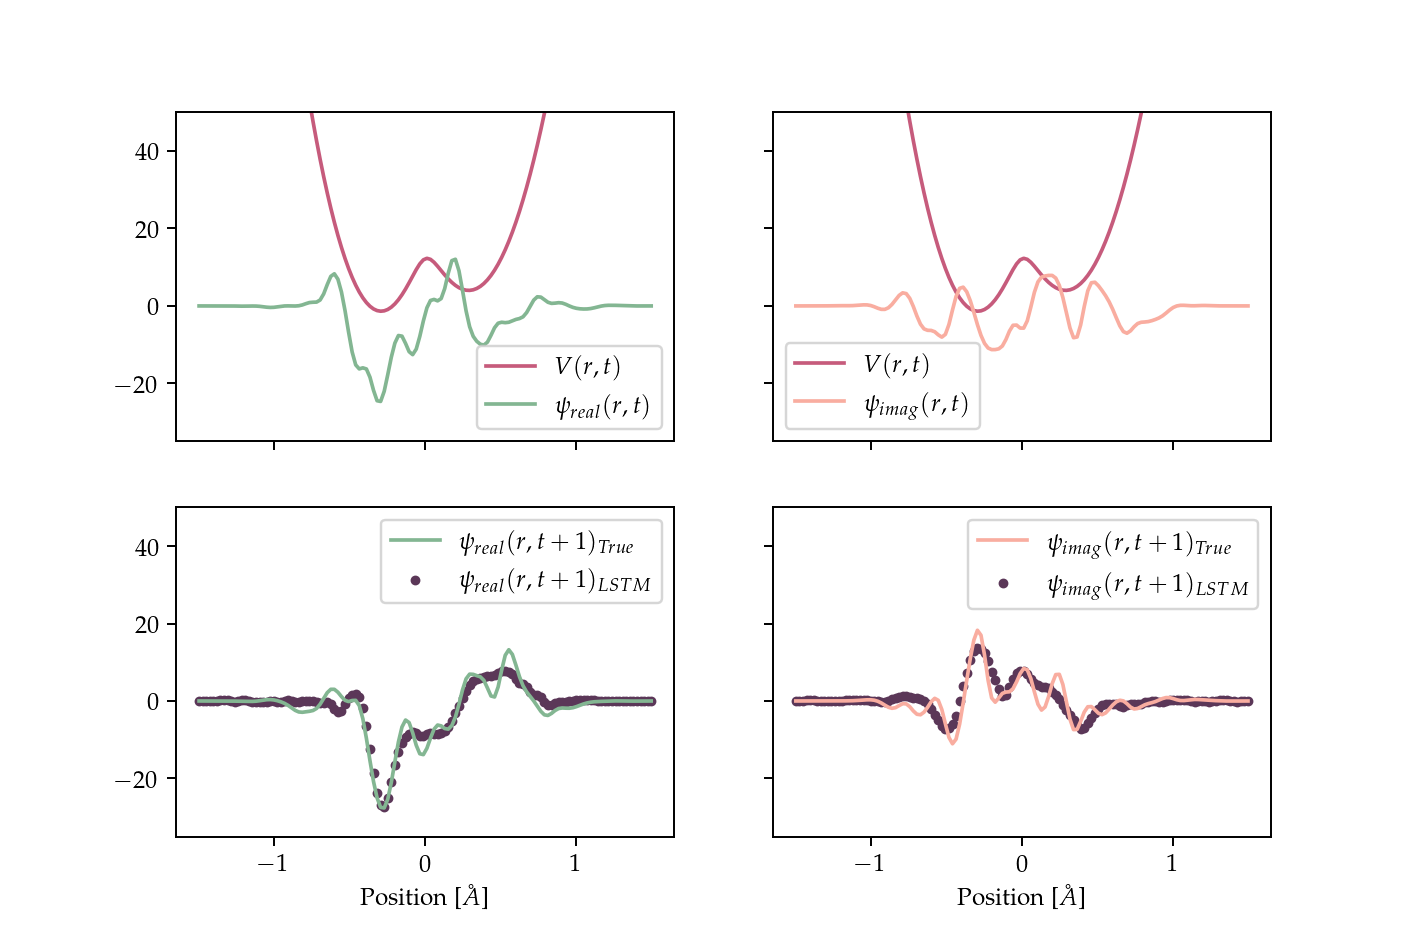

In [86]:
fig, axs = plt.subplots(2,2)
time = int(200)
r_n = np.linspace(a,b,n_grid)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, potential(time)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, wavefunction('real', time, 'input')*20, label="$\psi_{real}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, potential(time)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, wavefunction('complex', time, 'input')*20, label="$\psi_{imag}(r, t)$", color =color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, (wavefunction('real', time, 'output')+wavefunction('real', time, 'input'))*20, label="$\psi_{real}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, (wavefunction('real', time, 'prediction')+wavefunction('real', time, 'input'))*20, label="$\psi_{real}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, (wavefunction('complex', time, 'output')+wavefunction('complex', time, 'input'))*20, label="$\psi_{imag}(r, t+1)_{True}$", color =color[1])  # Escaled
axs[1,1].scatter(r_n, (wavefunction('complex', time, 'prediction')+wavefunction('complex', time, 'input'))*20, label="$\psi_{imag}(r, t+1)_{LSTM}$", color =color[4], marker='.')  # Escaled


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-35,50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]')
    ax.label_outer()
    pass
 
plt.gcf().set_size_inches(8, 5.33)
plt.legend()    
plt.show()

## Density comparison

In [80]:
def density(time, source):
    
    if time == 0:
        dens = (np.abs(np.vectorize(complex)(wavefunction('real',time,'input'),wavefunction('complex', time, 'input'))))**2
        return dens
    
    if source == 'output':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t
    
    if source == 'prediction':
        Ou_dens_t = (np.abs(np.vectorize(complex)(wavefunction('real',time,source),wavefunction('complex', time, source))))**2
        return Ou_dens_t

<IPython.core.display.Javascript object>


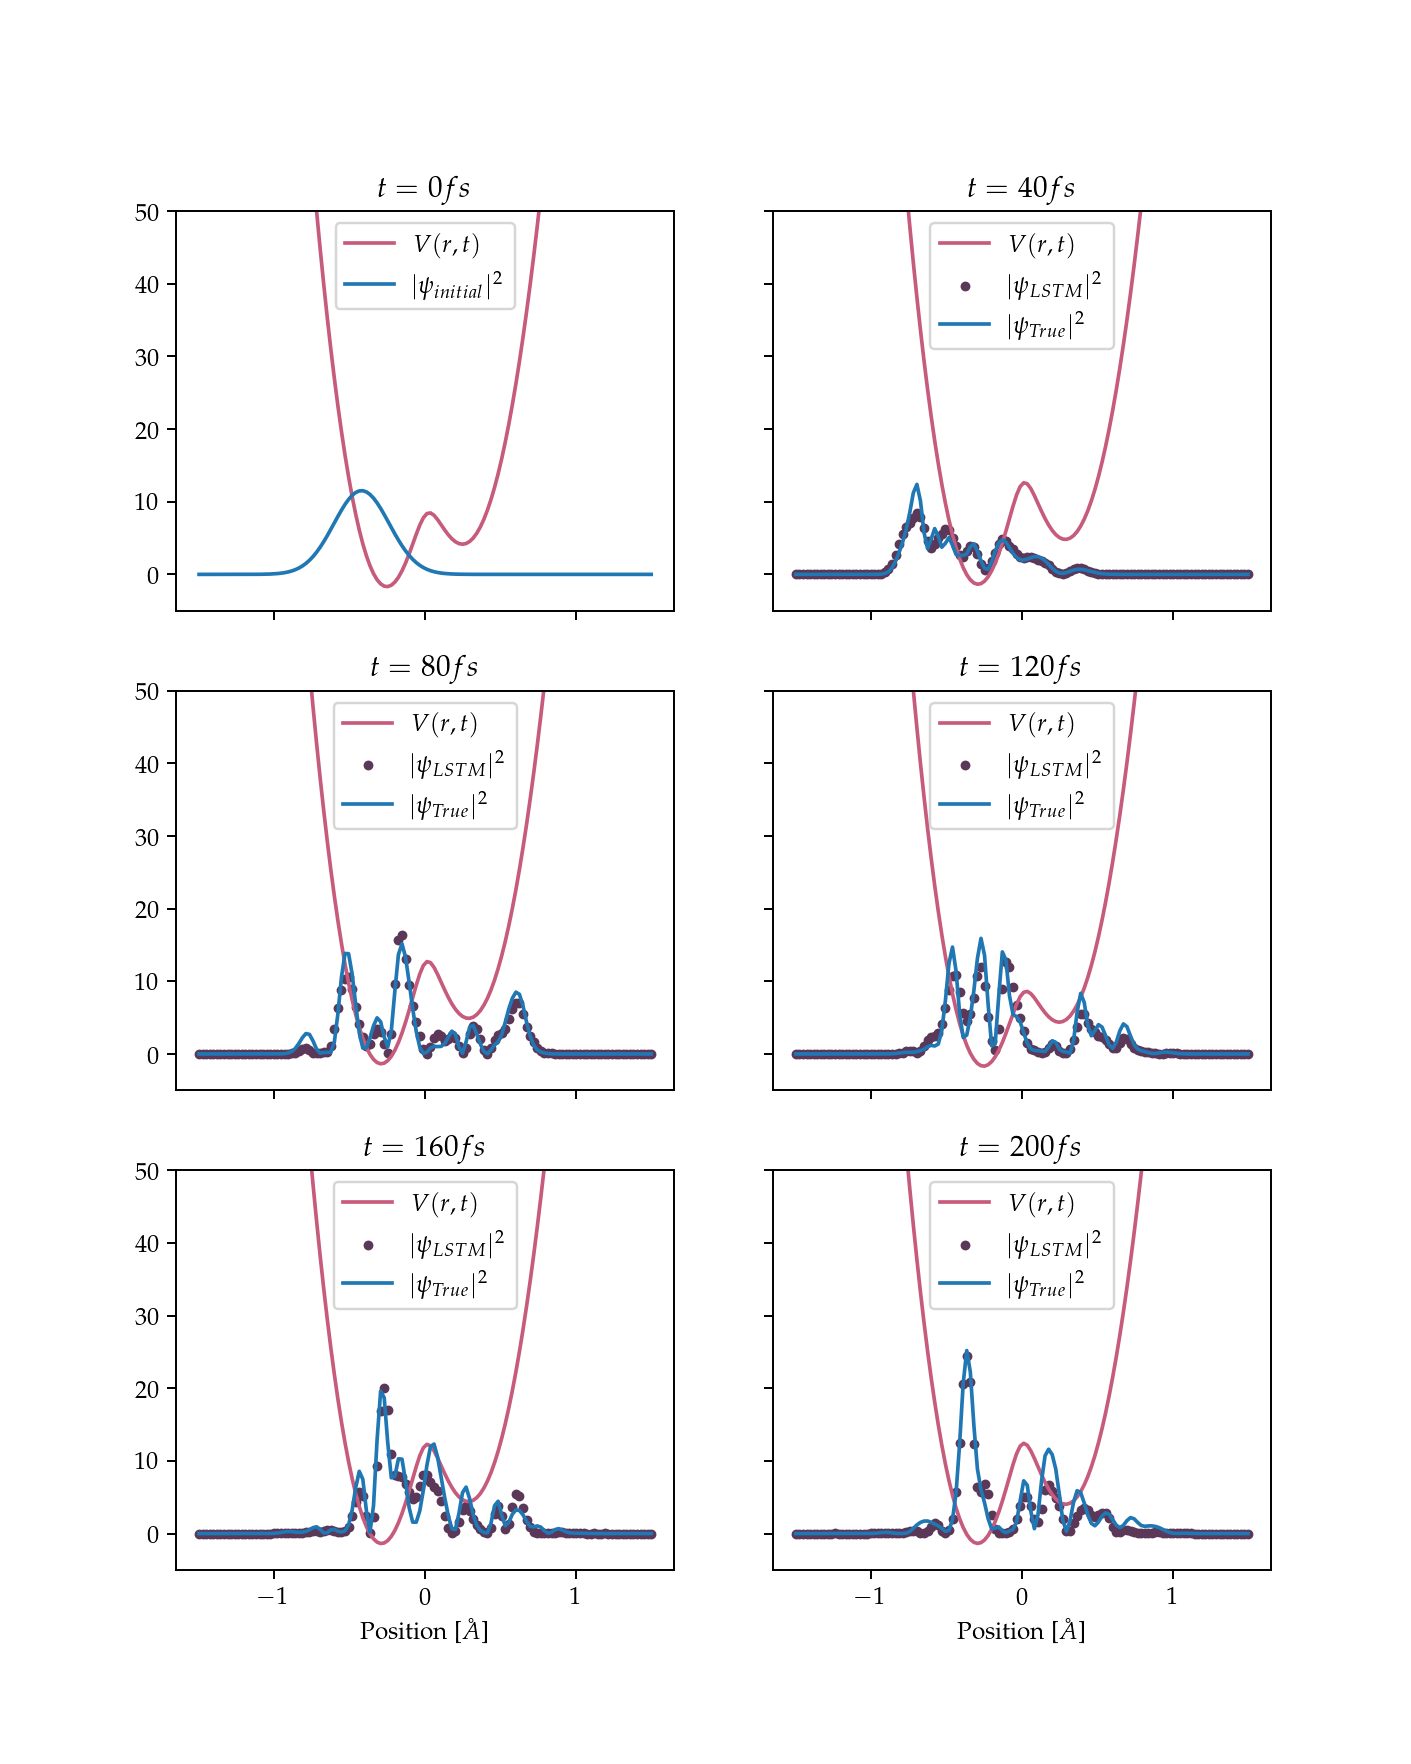

In [81]:
fig, ax = plt.subplots(3,2)

    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol

# t = 0
ax[0,0].plot(r_n, potential(0)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,0].plot(r_n, density(0, 'output')*10, label="$|\psi_{initial}|^{2}$")
ax[0,0].set_title("$t=0 fs$")

# t = 40
ax[0,1].plot(r_n, potential(40)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,1].scatter(r_n, density(40, 'prediction')*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[0,1].plot(r_n, density(40, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[0,1].set_title("$t=40 fs$")

# t = 80
ax[1,0].plot(r_n, potential(80)*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,0].scatter(r_n, density(80, 'prediction')*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,0].plot(r_n, density(80, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[1,0].set_title("$t=80 fs$")

# t = 120
ax[1,1].plot(r_n, potential(120)*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,1].scatter(r_n, density(120,'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,1].plot(r_n, density(120,'output')*10, label="$|\psi_{True}|^{2}$")
ax[1,1].set_title("$t=120 fs$")

# t = 160
ax[2,0].plot(r_n, potential(160)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,0].scatter(r_n, density(160,'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,0].plot(r_n, density(160, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[2,0].set_title("$t=160 fs$")

# t = 200
ax[2,1].plot(r_n, potential(199)*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,1].scatter(r_n, density(199, 'prediction')*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,1].plot(r_n, density(199, 'output')*10, label="$|\psi_{True}|^{2}$")
ax[2,1].set_title("$t=200 fs$")







for axr1 in ax:
    for axr11 in axr1:
        axr11.set_ylim([-5, 50])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]')
        
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax.flat:
    ax.label_outer()
    
    
plt.gcf().set_size_inches(8, 10)
#plt.legend()    
plt.show()

## Calculating accuracy

In [93]:
from torch import nn
criterion = nn.MSELoss().to(device)

In [105]:
def S_overlap(Psi_true, Psi_ANN, X):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test, Shape: (batch size, sequence lenght, 64)
    Psi_ANN: Evolution of wavepacket predicted with the model, Shape: (batch size, sequence lenght, 64)
    X : Evolution of wavepacket at time t-1
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article

    """
    
    Psi_true_re = Psi_true[:,:,0:n_grid] + X[:,:,0:n_grid]   # realpart of wavepacket predicted
    Psi_true_im = Psi_true[:,:,n_grid:n_grid*2] + X[:,:,n_grid:n_grid*2]  # imaginary part of wavepacket predicted 
    Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1)).to(device)
    
    Psi_ANN_re = Psi_ANN[:,:,0:n_grid]+ X[:,:,0:n_grid]  # realpart of wavepacket predicted
    Psi_ANN_im = -(Psi_ANN[:,:,n_grid:n_grid*2]+ X[:,:,n_grid:n_grid*2])  # imaginary part of wavepacket predicted (- because conjugate)
    Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1)).to(device)
    
    overl = Psi_A*Psi_t
    
    # Integrate over r (real integral + complex integral)
    # Trapezoid method in the grid r_n (angstroms -> au)
    
    r_n = (torch.linspace(-1.5,1.5,n_grid)*(1/0.5291775)).to(device)
    overl_real = overl.real
    overl_imag = overl.imag
    
    real_integ = torch.trapz(overl_real, r_n).to(device)
    imag_integ = torch.trapz(overl_imag, r_n).to(device)
    
    # Covert to phase and magnitude of the complex result
    S =  torch.sqrt(real_integ**2 + imag_integ**2).to(device)
    angle = torch.arctan(imag_integ/real_integ).to(device)
    
    # Mean S & angle
    S = torch.sum(S)/(batch_size*seq_len)
    angle = torch.sum(angle)/(batch_size*seq_len)
    
    
    return S, angle

In [106]:
def test1(dataloader, model, loss_fn):
    '''
    Same as test function but without writer to tensorboard
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y,pred,X)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

## Models accuracy  
- grid points = 128  
- trajectories of 1000 fs

In [ ]:
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_5040trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))

In [107]:
# model: 09-09-2024_1000fs_5040trainsamples.pth
test1(test_loader, model, criterion)

Test Error: 
 Accuracy Magnitude |S|: 73.5%
Test Error: 
 Accuracy phase: 0.0



In [108]:
# model: 09-09-2024_1000fs_1260trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_1260trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_1260trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_1260trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 70.0%
Test Error: 
 Accuracy phase: -0.0



In [109]:
# model: 09-09-2024_1000fs_1890trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_1890trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_1890trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_1890trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 71.3%
Test Error: 
 Accuracy phase: -0.0



In [116]:
# model: 09-09-2024_1000fs_2520trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_2520trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_2520trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_2520trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 71.8%
Test Error: 
 Accuracy phase: 0.0



In [115]:
# model: 09-09-2024_1000fs_3150trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_3150trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_3150trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_3150trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 72.6%
Test Error: 
 Accuracy phase: -0.0



In [114]:
# model: 09-09-2024_1000fs_3780trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_3780trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_3780trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_3780trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.1%
Test Error: 
 Accuracy phase: -0.0



In [113]:
# model: 09-09-2024_1000fs_4410trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_4410trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_4410trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_4410trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.1%
Test Error: 
 Accuracy phase: 0.0



In [112]:
# model: 09-09-2024_1000fs_5670trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_5670trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_5670trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_5670trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.1%
Test Error: 
 Accuracy phase: 0.0



In [111]:
# model: 09-09-2024_1000fs_6300trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_6300trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_6300trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_6300trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 73.4%
Test Error: 
 Accuracy phase: -0.0



In [110]:
# model: 09-09-2024_1000fs_630trainsamples.pth
model_path = '/home/jessica/Tesis/Paper/models/09-09-2024_1000fs_630trainsamples.pth'
model = torch.load(model_path,map_location=torch.device('cpu'))
print('model: 09-09-2024_1000fs_630trainsamples.pth')
test1(test_loader, model, criterion)

model: 09-09-2024_1000fs_630trainsamples.pth
Test Error: 
 Accuracy Magnitude |S|: 67.3%
Test Error: 
 Accuracy phase: 0.0



## Results

### Accuracy calculated using Data_128grid_new2.h5 and eq. 11 absolute magnitude |S| ($\theta=0.0$) all models
- Total of data: 3000
- grid points = 128  
- trajectories of 1000 fs


|Model|$|S|$|
|:----|----|
|09-09-2024_1000fs_5040trainsamples.pth|73.5%|
|09-09-2024_1000fs_1260trainsamples.pth|70.0%|
|09-09-2024_1000fs_1890trainsamples.pth|73.5%|
|09-09-2024_1000fs_1260trainsamples.pth|70.0%|
|09-09-2024_1000fs_1890trainsamples.pth|71.3%|
|09-09-2024_1000fs_2520trainsamples.pth|71.8%|
|09-09-2024_1000fs_3150trainsamples.pth|72.6%|
|09-09-2024_1000fs_3780trainsamples.pth|73.1%|
|09-09-2024_1000fs_4410trainsamples.pth|73.1%|
|09-09-2024_1000fs_5670trainsamples.pth|73.1%|
|09-09-2024_1000fs_6300trainsamples.pth|73.4%|
|09-09-2024_1000fs_630trainsamples.pth|67.3%|

